In [1]:
import sys
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tensorflow as tf
import xgboost as xgb
from wheather_data_prediction import calculate_POA, lstm_atten_train, cnn_lstm_atten_train,transformer_train
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

random.seed(30)
np.random.seed(30)
tf.random.set_seed(30)


2024-08-17 13:40:13.972496: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-17 13:40:14.174492: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-17 13:40:17.029980: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


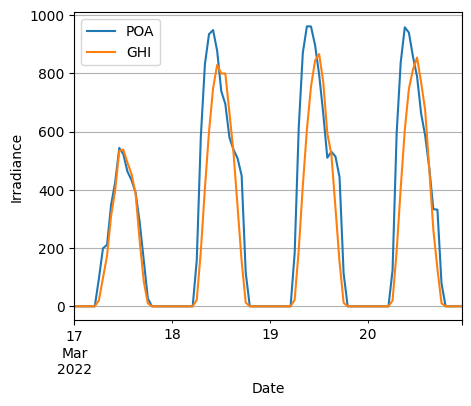

In [2]:
#Reading NASA dataset from exact NEOEN site 
# Read the CSV data into a Pandas DataFrame
from io import StringIO
df_met_nasa = pd.read_csv('/mnt/data-r6/ahilan/dataset/neoen/process/NASA-weather-data-sattelite_20200101_20240131_034d76S_145d93E_LST.csv',skiprows=16)
df_met_nasa = df_met_nasa.rename(columns={'MO': 'MONTH','DY': 'DAY', 'HR': 'HOUR' , 'ALLSKY_SFC_SW_DWN' : 'GHI',  'ALLSKY_SFC_SW_DNI': 'DNI', 'ALLSKY_SFC_SW_DIFF' : 'DHI', 'T2M': 'Temp', 'WS10M': 'Wind', 'QV2M': 'HUMDY', 'ALLSKY_SRF_ALB' : 'ALBEDO', 'PRECTOTCORR': 'PRECIP'})
df_met_nasa['datetime'] = pd.to_datetime(df_met_nasa[['YEAR', 'MONTH', 'DAY', 'HOUR']])
df_met_nasa.drop(columns=['YEAR', 'MONTH', 'DAY', 'HOUR'], inplace=True)
df_met_nasa.set_index('datetime', inplace=True)

lat, lon = -34.76, 145.93
ghi = df_met_nasa['GHI']
dni = df_met_nasa['DNI']
dhi = df_met_nasa['DHI']
albedo=df_met_nasa['ALBEDO']

azimuth_angle = 0  # azimuth angle (north-facing)

start_date = df_met_nasa.index.min()
end_date = df_met_nasa.index.max()

df_met_nasa['POA'] = calculate_POA(ghi,dni,dhi,albedo,lat,lon,azimuth_angle,start_date=start_date,end_date=end_date)

start_date = '2022-03-17'
end_date = '2022-03-20'


df_met_nasa['POA'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label='POA')
df_met_nasa['GHI'][start_date:end_date].resample('H').mean().plot(figsize=(5, 4), label='GHI')
plt.legend()
plt.ylabel('Irradiance')
plt.xlabel('Date')
plt.grid(True)
plt.show()


df_met_nasa_temp = df_met_nasa[['Temp', 'POA', 'Wind','GHI','HUMDY']]
df_met_nasa_temp = df_met_nasa_temp.rename(columns={'Temp': 'Temp_nasa','POA': 'POA_nasa', 'Wind': 'Wind_nasa', 'GHI' : 'GHI_nasa','HUMDY': 'HUMDY_nasa'})

df_met_measured = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/met_5min.pkl')
df_met_measured = df_met_measured.rename(columns={'Timestamp': 'time'})
df_met_measured.set_index('time', inplace=True)

df_met_measured = df_met_measured.shift(periods=-90, freq='T')

df_met_measured = df_met_measured[['Temp','POA','Wind','Tmod']].resample('H').mean()
df_met_measured = df_met_measured.rename(columns={'Temp': 'Temp_mes','POA': 'POA_mes', 'Wind': 'Wind_mes', 'Tmod': 'Tmod_mes'})

data = pd.merge(df_met_measured, df_met_nasa_temp, left_index=True, right_index=True)


data = data[data['Temp_mes'] < 40]
data = data[data['Temp_mes'] > 0]

8.696952424413226
18.272323418790045


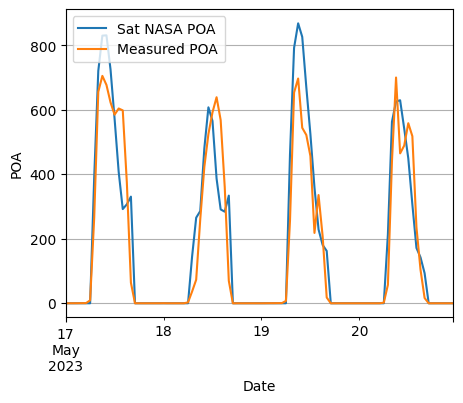

In [3]:
#start_date = data.index.min()
#end_date = data.index.max()
from sklearn.metrics import mean_squared_error, r2_score

def mape(actual, predicted):
    return np.mean(np.abs((actual - predicted) / actual)) * 100


# calculate RMSE
rmse = mean_squared_error(data['Temp_mes'], data['Temp_nasa'])

mape = mape(data['Temp_mes'], data['Temp_nasa'])

print(rmse)
print(mape)

start_date = '2023-05-17'
end_date = '2023-05-20'

feat_nasa = 'POA_nasa'
feat_mes ='POA_mes'
label_nasa = 'Sat NASA POA '
label_mes = 'Measured POA'
ylabel = 'POA'

data[feat_nasa][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label=label_nasa)
data[feat_mes][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label=label_mes)
plt.legend()
plt.ylabel(ylabel)
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [4]:
# Estimating the Sandia Module Temperature Model coefficnet U0 and U1
from sklearn.linear_model import LinearRegression

data_lr = data

# Ensure your dataset contains columns: 'T_m', 'T_a', 'v', 'G_POA'
T_m = data_lr['Tmod_mes']
T_a = data_lr['Temp_mes']
v = data_lr['Wind_mes']
G_POA = data_lr['POA_mes']
eta = 0.1737  # Efficiency

data_lr['Y'] = data_lr['POA_mes'] * (1 - eta)
data_lr['X1'] = data_lr['Tmod_mes'] - data_lr['Temp_mes']
data_lr['X2'] = data_lr['X1'] * data_lr['Wind_mes']

# Filter out infinite or NaN values
data_lr.replace([np.inf, -np.inf], np.nan, inplace=True)
data_lr.dropna(inplace=True)

# Define features and target
X = data_lr[['X1', 'X2']]
Y = data_lr['Y']


# Create a linear regression model
model = LinearRegression()

# Fit the model
model.fit(X, Y)

# Retrieve the coefficients
U0 = model.coef_[0]
U1 = model.coef_[1]

print(f'U0: {U0}, U1: {U1}')
#print(f'U1: {U1}')

U0: 23.784114795895526, U1: 3.778162785816899


Index(['Temp_nasa', 'POA_nasa', 'Wind_nasa', 'GHI_nasa', 'HUMDY_nasa',
       'Tmod_nasa'],
      dtype='object')


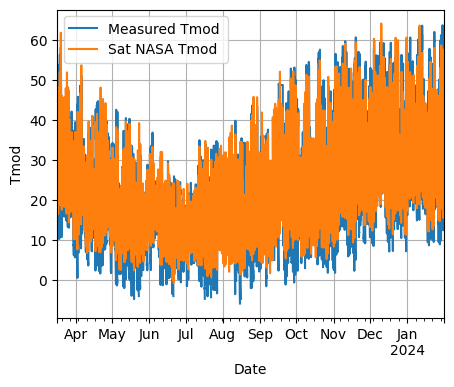

In [5]:
# Estimating module temperature using Sandia Module Temperature Model and ambient temperature, wind speed and POA
def estimate_module_temperature(T_amb, E, eta, U0, U1, v):
    return T_amb + (E * (1 - eta)) / (U0 + U1 * v)

# Example values
T_amb = df_met_nasa_temp['Temp_nasa']  # °C
E = df_met_nasa_temp['POA_nasa']    # W/m²
eta = 0.1737  # Efficiency
#U0 = 25     # W/m²K
U0 = 23.784114795895526
#U1 = 6.84   # W/m²K per m/s
U1 = 3.778162785816899
v = df_met_nasa_temp['Wind_nasa']  # m/s


df_met_nasa_temp['Tmod_nasa'] = estimate_module_temperature(T_amb, E, eta, U0, U1, v)

df_met_nasa = df_met_nasa_temp
print(df_met_nasa.columns)

#Saving the nasa date on pkl file
df_met_nasa.to_pickle('/home/ahilan/gen-research/neoen-site/data/neoen_weather_nasa_sat_data.pkl')

start_date = data.index.min()
end_date = data.index.max()

#start_date = '2023-05-17'
#end_date = '2023-05-20'

feat_nasa = 'Tmod_nasa'
feat_mes ='Tmod_mes'
label_nasa = 'Sat NASA Tmod '
label_mes = 'Measured Tmod'
ylabel = 'Tmod'

data[feat_mes][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label=label_mes)
df_met_nasa_temp[feat_nasa][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label=label_nasa)

plt.legend()
plt.ylabel(ylabel)
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [6]:
# LSTM attention modelling to predict actual temperature from satellite data temperature
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

data = pd.merge(df_met_measured, df_met_nasa_temp, left_index=True, right_index=True)
data = data[['Temp_mes','Wind_mes', 'POA_mes', 'Tmod_mes','Wind_nasa', 'Temp_nasa', 'POA_nasa', 'HUMDY_nasa','Tmod_nasa']]

#measured_vs_nasa_mse = mean_squared_error(data['Temp_mes'].values, data['Temp_nasa'].values)
#print(measured_vs_nasa_mse)

data = data[data['Temp_mes'] < 40]
data = data[data['Temp_mes'] > 0]

#measured_vs_nasa_mse = mean_squared_error(data['Temp_mes'].values, data['Temp_nasa'].values)
#print(measured_vs_nasa_mse)


#data = data[data['Wind_mes']<12]
#data = data[data['Wind_nasa']<12]

# Filtering constant values
# Define the window size
window_size = 3

# Check if the values in the rolling window are the same
data['constant'] = data['Tmod_mes'].rolling(window=window_size).apply(lambda x: np.all(x == x[0]), raw=True)


# Fill NaN values with 0 (occurs for the first 'window_size - 1' elements)
data['constant'].fillna(0, inplace=True)
data['constant'] = data['constant'].astype(bool)

# Filter out constant value rows
data_filtered = data[~data['constant']].drop(columns=['constant'])
data = data_filtered

#start_date = '2023-03-16 04:00:00'
#end_date = '2023-06-16 04:00:00'
#data = data_filtered[start_date:end_date]

measured_vs_nasa_mse = mean_squared_error(data['Tmod_mes'].values, data['Tmod_nasa'].values)
print(measured_vs_nasa_mse)

start_date = data.index.min()
end_date = data.index.max()

feat_target = 'Tmod_mes'
sat_data = 'Tmod_nasa'
feat_pred = 'Tmod_pred'
y_label = 'Module Temperature'

# Split the data into features (X) and target (y)
X = data[['Tmod_nasa','Wind_nasa','Temp_nasa', 'POA_nasa','HUMDY_nasa']].values
y = data[feat_target].values


# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Prepare the data for LSTM (convert to sequences)
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

seq_len = 24  # You can adjust this based on your data
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len)


# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)


model = lstm_atten_train(X_train, X_test, y_train, y_test, feat_target, sat_data, feat_pred, y_label,batch_size=64, epochs=100)
model.save('/home/ahilan/gen-research/neoen-site/models/weather_prediction/Tmod_lstm_without_attention_one_year_data_best_model_epcho100.h5')

model.summary

# Make predictions
y_train_pred = scaler_y.inverse_transform(model.predict(X_train))
y_test_pred = scaler_y.inverse_transform(model.predict(X_test))
y_pred = scaler_y.inverse_transform(model.predict(X_seq))

# Calculate metrics
y_train_inv = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

y_pred_combine = np.concatenate((y_train_pred,y_test_pred),axis=0)
y_combined = np.concatenate((y_train_inv,y_test_inv),axis=0)

measured_vs_nasa_mse = mean_squared_error(data[feat_target].values, data[sat_data].values)
measured_vs_predicted_mse = mean_squared_error(y_combined,y_pred_combine)

train_mse = mean_squared_error(y_train_inv, y_train_pred)
test_mse = mean_squared_error(y_test_inv, y_test_pred)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Measured vs Nasa MSE: {measured_vs_nasa_mse}')
print(f'Measured vs Predicted MSE: {measured_vs_predicted_mse}')



plt.plot(y[24:84], color='blue', label=feat_target)
plt.plot(X[24:84,1], color='red', label=sat_data)
plt.plot(y_pred[0:60], color='green', label=feat_pred)
plt.title('Training Data')
plt.xlabel('Time')
plt.ylabel(y_label)
plt.legend()
plt.show()

# Plot the results
plt.figure(figsize=(5, 4))
print(X.shape)
# Training data
plt.scatter(X[:,1], y, color='blue', label=feat_target)
plt.scatter(X[24:,1], y_pred, color='red', label=feat_pred)
plt.title('Training Data')
plt.xlabel(sat_data)
plt.ylabel(feat_target)
plt.legend()
plt.grid(True)
plt.show()

data_ = data.iloc[24:]
data_[feat_pred] = y_pred

start_date = '2023-05-17'
end_date = '2023-05-20'

data.iloc[24:][feat_target][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label=feat_target)
data.iloc[24:][sat_data][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label=sat_data)
data_[feat_pred][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label=feat_pred)
plt.legend()
plt.title('Training Data')
plt.ylabel(y_label)
plt.xlabel('Date')
plt.grid(True)
plt.show()

25.77247816897658


"\nmodel = lstm_atten_train(X_train, X_test, y_train, y_test, feat_target, sat_data, feat_pred, y_label,batch_size=64, epochs=100)\nmodel.save('/home/ahilan/gen-research/neoen-site/models/weather_prediction/Tmod_lstm_without_attention_one_year_data_best_model_epcho100.h5')\n\nmodel.summary\n\n# Make predictions\ny_train_pred = scaler_y.inverse_transform(model.predict(X_train))\ny_test_pred = scaler_y.inverse_transform(model.predict(X_test))\ny_pred = scaler_y.inverse_transform(model.predict(X_seq))\n\n# Calculate metrics\ny_train_inv = scaler_y.inverse_transform(y_train.reshape(-1, 1))\ny_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))\n\ny_pred_combine = np.concatenate((y_train_pred,y_test_pred),axis=0)\ny_combined = np.concatenate((y_train_inv,y_test_inv),axis=0)\n\nmeasured_vs_nasa_mse = mean_squared_error(data[feat_target].values, data[sat_data].values)\nmeasured_vs_predicted_mse = mean_squared_error(y_combined,y_pred_combine)\n\ntrain_mse = mean_squared_error(y_train_

In [ ]:
from tensorflow.keras.utils import plot_model
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, LSTM, Dense, Attention, Concatenate, Dropout, MultiHeadAttention, GlobalAveragePooling1D, Bidirectional
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.layers import Input, MultiHeadAttention, LayerNormalization, Dense
from keras.regularizers import l2
from tensorflow.keras.layers import Bidirectional, LSTM, Layer, Dot, Activation, GlobalAveragePooling1D

# Define the model
input_layer = Input(shape=input_shape)
lstm = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))(input_layer)
lstm = Dropout(0.3)(lstm)
lstm = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001))(lstm)
lstm = Dropout(0.3)(lstm)
attention = Attention()([lstm, lstm])
concat = Concatenate()([lstm, attention])
lstm_out_2 = LSTM(64,kernel_regularizer=l2(0.001))(concat)
lstm_out_2 = Dropout(0.3)(lstm_out_2)
outputs = Dense(1)(lstm_out_2)
model = Model(input_layer, outputs)


# Plot the model
plot_model(model, to_file='/home/ahilan/gen-research/neoen-site/models/weather_prediction/LSTM_with_attention.png', show_shapes=True, show_layer_names=True)


In [ ]:
from keras.models import load_model
from sklearn.preprocessing import StandardScaler, MinMaxScaler

model = load_model('/home/ahilan/gen-research/neoen-site/models/weather_prediction/Tmod_lstm_with_attention_one_year_data_best_model_epcho100.h5')

X_nasa = df_met_nasa_temp[['Tmod_nasa','Wind_nasa', 'Temp_nasa', 'POA_nasa', 'HUMDY_nasa']].values


data = pd.merge(df_met_measured, df_met_nasa_temp, left_index=True, right_index=True)
data = data[['Temp_mes','Wind_mes', 'POA_mes', 'Tmod_mes','Wind_nasa', 'Temp_nasa', 'POA_nasa', 'HUMDY_nasa','Tmod_nasa']]


data = data[data['Temp_mes'] < 40]
data = data[data['Temp_mes'] > 0]

#data = data[data['Wind_mes']<12]
#data = data[data['Wind_nasa']<12]

# Filtering constant values
# Define the window size
window_size = 3

# Check if the values in the rolling window are the same
data['constant'] = data['Tmod_mes'].rolling(window=window_size).apply(lambda x: np.all(x == x[0]), raw=True)


# Fill NaN values with 0 (occurs for the first 'window_size - 1' elements)
data['constant'].fillna(0, inplace=True)
data['constant'] = data['constant'].astype(bool)

# Filter out constant value rows
data_filtered = data[~data['constant']].drop(columns=['constant'])
data = data_filtered

#del data
#start_date = '2023-03-16 04:00:00'
#end_date = '2023-06-16 04:00:00'
#data = data_filtered[start_date:end_date]

feat_target = 'Tmod_mes'
sat_data = 'Tmod_nasa'
feat_pred = 'Tmod_pred'
y_label = 'Module Temperature'

X = data[['Tmod_nasa','Wind_nasa', 'Temp_nasa', 'POA_nasa', 'HUMDY_nasa']].values
y = data['Tmod_mes'].values

# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Prepare the data for LSTM (convert to sequences)
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

seq_len = 24  # You can adjust this based on your data
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

# Make predictions
y_train_pred = scaler_y.inverse_transform(model.predict(X_train))
y_test_pred = scaler_y.inverse_transform(model.predict(X_test))
y_pred = scaler_y.inverse_transform(model.predict(X_seq))

# Calculate metrics
y_train_inv = scaler_y.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler_y.inverse_transform(y_test.reshape(-1, 1))

y_pred_combine = np.concatenate((y_train_pred,y_test_pred),axis=0)
y_combined = np.concatenate((y_train_inv,y_test_inv),axis=0)

measured_vs_nasa_mse = mean_squared_error(data[feat_target].values, data[sat_data].values)
measured_vs_predicted_mse = mean_squared_error(y_combined,y_pred_combine)

train_mse = mean_squared_error(y_train_inv, y_train_pred)
test_mse = mean_squared_error(y_test_inv, y_test_pred)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Measured vs Nasa MSE: {measured_vs_nasa_mse}')
print(f'Measured vs Predicted MSE: {measured_vs_predicted_mse}')



# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_nasa_scaled = scaler_X.fit_transform(X_nasa)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

## Prepare the data for LSTM (convert to sequences)
def create_sequences(X, time_steps=1):
    Xs = []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
    return np.array(Xs)

seq_len = 24  # You can adjust this based on your data
X_nasa_seq = create_sequences(X_nasa_scaled, seq_len)

y_nasa_pred_Tmod = scaler_y.inverse_transform(model.predict(X_nasa_seq))

df_met_nasa_ = df_met_nasa.iloc[24:]
df_met_nasa_[feat_pred] = y_nasa_pred_Tmod


start_date_sat = df_met_nasa_.index.min()
end_date_sat = df_met_nasa_.index.max()

start_date_mes = data.index.min()
end_date_mes = data.index.max()


data[feat_target][start_date_mes:end_date_mes].resample('H').mean().plot(
    figsize=(5, 4),
    label=feat_target,
    color='lightblue',  # Use a light color for the first plot
    alpha=0.9           # Optional: Adjust opacity to make it lighter
)

df_met_nasa_[feat_pred][start_date_sat:end_date_sat].resample('H').mean().plot(
    figsize=(5, 4),
    label=feat_pred,
    color='lightcoral',  # Use a light color for the second plot
    alpha=0.6            # Optional: Adjust opacity to make it lighter
)

plt.legend()
plt.title('Training Data')
plt.ylabel(y_label)
plt.xlabel('Date')
plt.grid(True)
plt.show()

In [ ]:
df_met_nasa_temp_ = df_met_nasa_temp.iloc[24:]
df_met_nasa_temp_['Tmod_pred'] = y_nasa_pred_Tmod
df_met_nasa_temp_['Temp_pred'] = y_nasa_pred_Temp
df_met_nasa_temp_['POA_pred'] = y_nasa_pred_POA
df_met_nasa = df_met_nasa_temp_
#Saving the nasa date on pkl file
df_met_nasa.to_pickle('/home/ahilan/gen-research/neoen-site/data/neoen_weather_nasa_sat_data_and_predicted_data_lstm_with_attention.pkl')

In [7]:
#Estimating the PR and WCPR on measured 1 year data
df_pow = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/pow_inv-32-A_5min.pkl')
df_POA = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/poa_5min.pkl')
df_Tmod = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/tmod_5min.pkl')
df_met = pd.read_pickle('/mnt/data-r6/ahilan/dataset/neoen/process/met_5min.pkl')
df_T = df_met[['Temp','Timestamp']]
df_T = df_T.rename(columns={'Temp': 'Temp_mes','Timestamp': 'time'})

#del df_neoen_measured_data
#del df_met_nasa_predicted
#del df_neoen_data_nasa_predicted_data

df_inner = pd.merge(df_pow, df_POA, on='time', how='inner')
df_inner2 = pd.merge(df_inner, df_Tmod, on='time', how='inner')
df = pd.merge(df_inner2, df_T, on='time', how='inner')


df.set_index('time', inplace=True)
df_neoen_measured_data = df.rename(columns={'power': 'Power_mes','value_x': 'POA_mes','value_y': 'Tmod_mes' })

df_neoen_mes = df_neoen_measured_data[['Power_mes','Temp_mes','POA_mes','Tmod_mes']].resample('H').mean()
#df_neoen_mes = df_neoen_measured_data[df_neoen_measured_data['POA_mes']>0]
#df_neoen_mes = df_neoen_mes[df_neoen_mes['Tmod_mes']>0]



df_pow.set_index('time', inplace=True)
df_neoen_measured_power = df_pow[['power']].resample('H').mean()

df_met_nasa_predicted = pd.read_pickle('/home/ahilan/gen-research/neoen-site/data/neoen_weather_nasa_sat_data_and_predicted_data_lstm_with_attention.pkl')

df_met_nasa = df_met_nasa_predicted[['POA_nasa','Tmod_nasa']]
#df_met_nasa = df_met_nasa[df_met_nasa['POA_nasa']>0]
#df_met_nasa = df_met_nasa[df_met_nasa['Tmod_nasa']>0]

df_met_pred = df_met_nasa_predicted[['POA_pred','Tmod_pred']]
#df_met_pred = df_met_pred[df_met_pred['POA_pred']>0]
#df_met_pred = df_met_pred[df_met_pred['Tmod_pred']>0]



df_neoen_nasa = pd.merge(df_neoen_measured_power, df_met_nasa, left_index=True, right_index=True)
df_neoen_pred = pd.merge(df_neoen_measured_power, df_met_pred, left_index=True, right_index=True)

In [8]:
POA_std = 1000
#Each inverter each with an average of 5,700 modules for a 2 MW nominal maximum power input
#with output AC power limited to 1.7 MW

Capacity = 2.0

df_neoen_mes['PR_mes_data'] = (df_neoen_mes['Power_mes'] * POA_std) / (Capacity * df_neoen_mes['POA_mes'])

T_std = 25 
#T_avg = df['Tmod'].mean()
alpha = 0.004

correction_cofficient = (1 - alpha * (T_std - df_neoen_mes['Tmod_mes']))
df_neoen_mes['WCPR_mes_data'] = df_neoen_mes['PR_mes_data']/correction_cofficient


df_neoen_nasa['PR_nasa_data'] = (df_neoen_nasa['power'] * POA_std) / (Capacity * df_neoen_nasa['POA_nasa'])

T_std = 25 
#T_avg = df['Tmod'].mean()
alpha = 0.004

correction_cofficient = (1 - alpha * (T_std - df_neoen_nasa['Tmod_nasa']))
df_neoen_nasa['WCPR_nasa_data'] = df_neoen_nasa['PR_nasa_data']/correction_cofficient


df_neoen_pred['PR_pred_data'] = (df_neoen_pred['power'] * POA_std) / (Capacity * df_neoen_pred['POA_pred'])

T_std = 25 
#T_avg = df['Tmod'].mean()
alpha = 0.004

correction_cofficient = (1 - alpha * (T_std - df_neoen_pred['Tmod_pred']))
df_neoen_pred['WCPR_pred_data'] = df_neoen_pred['PR_pred_data']/correction_cofficient


2020-09-22 07:00:00
2023-12-31 19:00:00


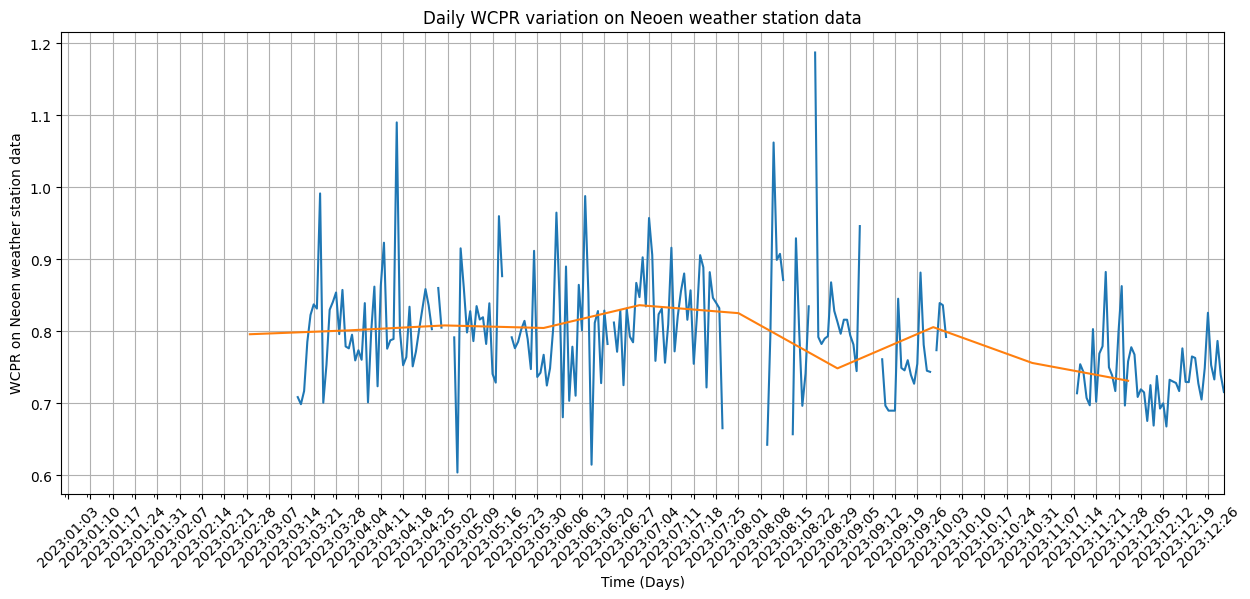

time
2023-12-31    0.778475
Freq: A-DEC, Name: WCPR_mes_data, dtype: float64


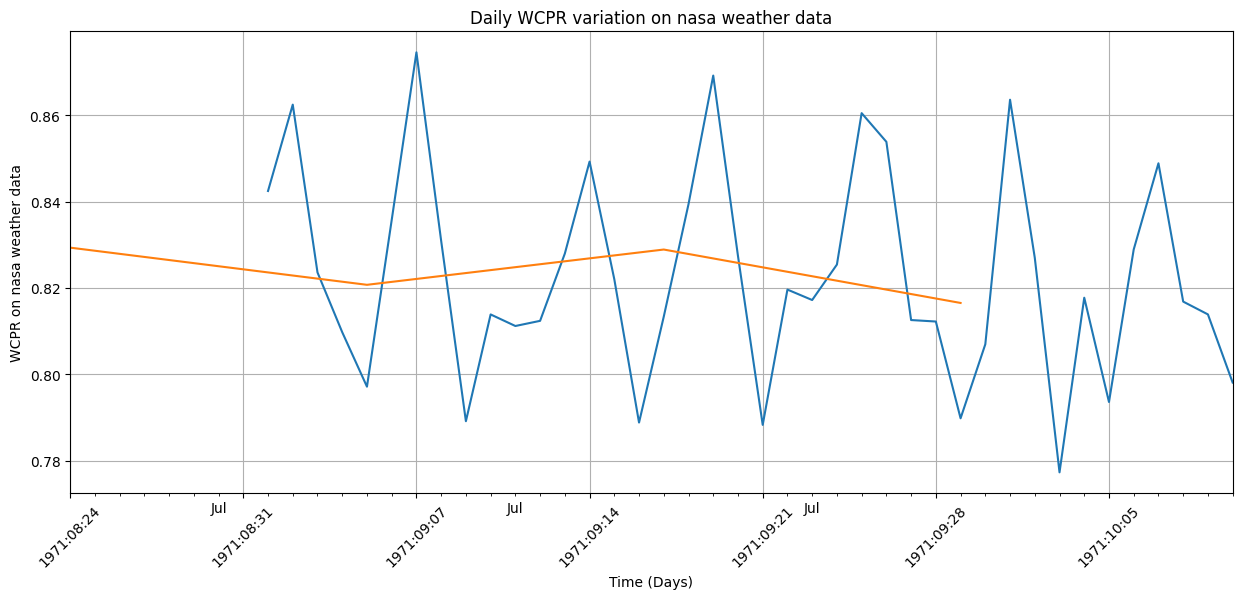

2020-12-31    0.829335
2021-12-31    0.820728
2022-12-31    0.828896
2023-12-31    0.816528
Freq: A-DEC, Name: WCPR_nasa_data, dtype: float64


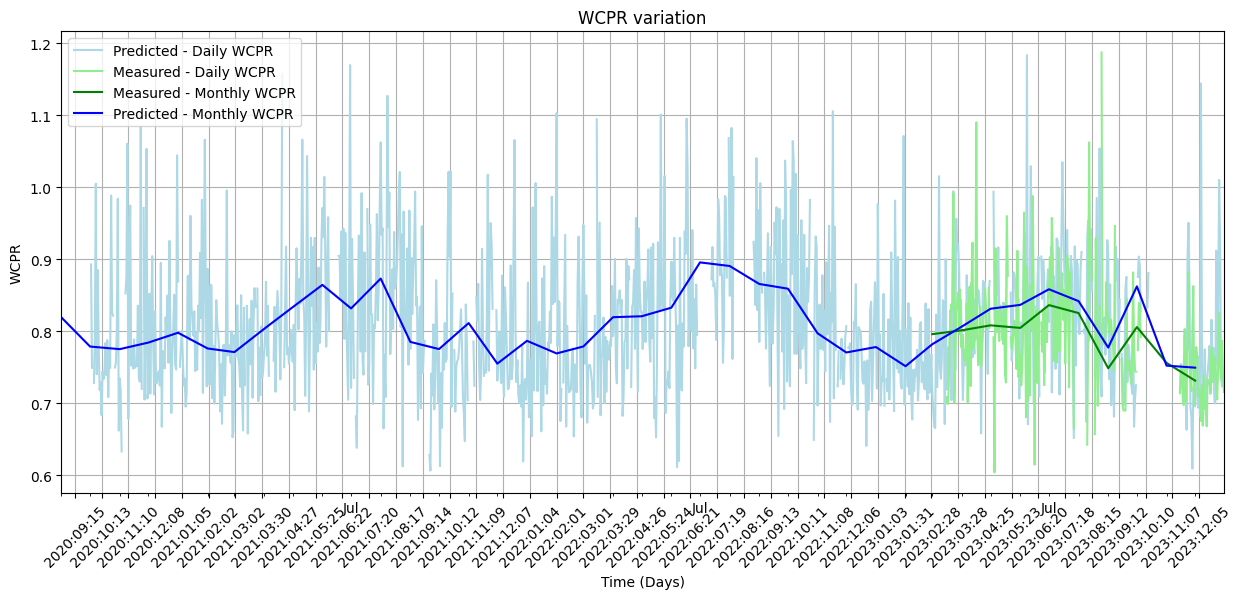

2020-12-31    0.780994
2021-12-31    0.801044
2022-12-31    0.814455
2023-12-31    0.795338
Freq: A-DEC, Name: WCPR_pred_data, dtype: float64


In [22]:
WCPR_mes = df_neoen_mes[df_neoen_mes['WCPR_mes_data'] > 0.6]
WCPR_mes = WCPR_mes[WCPR_mes['WCPR_mes_data'] <= 1.2]

WCPR_nasa = df_neoen_nasa[df_neoen_nasa['WCPR_nasa_data'] > 0.6]
WCPR_nasa = WCPR_nasa[WCPR_nasa['WCPR_nasa_data'] <= 1.2]

WCPR_pred = df_neoen_pred[df_neoen_pred['WCPR_pred_data'] > 0.6]
WCPR_pred = WCPR_pred[WCPR_pred['WCPR_pred_data'] <= 1.2]

#start_date = WCPR_nasa.index.min()
#end_date = WCPR_nasa.index.max()
start_date = WCPR_nasa.index.min()
#end_date = WCPR_nasa.index.max()
end_date = '2023-12-31 19:00:00'
print(start_date)
print(end_date)

#WCPR_measured_filtered = WCPR_measured_filtered[start_date:end_date]['WCPR_mes_data'].resample('D').mean()

plt.figure(figsize=(15, 6))
#plt.scatter(WCPR_measured_filtered['WCPR_mes_data'].index.date, WCPR_measured_filtered['WCPR_mes_data'])

WCPR_mes['WCPR_mes_data'][start_date:end_date].resample('D').mean().plot(figsize=(15, 6))
WCPR_mes['WCPR_mes_data'][start_date:end_date].resample('M').mean().plot(figsize=(15, 6))
WCPR_mes['WCPR_mes_data'][start_date:end_date].resample('Y').mean().plot(figsize=(15, 6))


# Format x-axis to show every hour
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y:%m:%d'))
plt.title('Daily WCPR variation on Neoen weather station data')
plt.xlabel('Time (Days)')
plt.ylabel('WCPR on Neoen weather station data')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()
print(WCPR_mes['WCPR_mes_data'][start_date:end_date].resample('Y').mean())

##############################################################################################################

#start_date = WCPR_nasa_filtered.index.min()
#end_date = WCPR_nasa_filtered.index.max()

#WCPR_measured_filtered = WCPR_measured_filtered[start_date:end_date]['WCPR_mes_data'].resample('D').mean()

plt.figure(figsize=(15, 6))
#plt.scatter(WCPR_nasa_filtered['WCPR_nasa_data'].index.date, WCPR_nasa_filtered['WCPR_nasa_data'])

#WCPR_nasa['WCPR_nasa_data'][start_date:end_date].resample('D').mean().plot(figsize=(15, 6))
WCPR_nasa['WCPR_nasa_data'][start_date:end_date].resample('M').mean().plot(figsize=(15, 6))
WCPR_nasa['WCPR_nasa_data'][start_date:end_date].resample('Y').mean().plot(figsize=(15, 6))


# Format x-axis to show every hour
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y:%m:%d'))
plt.title('Daily WCPR variation on nasa weather data')
plt.xlabel('Time (Days)')
plt.ylabel('WCPR on nasa weather data')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()
print(WCPR_nasa['WCPR_nasa_data'][start_date:end_date].resample('Y').mean())

##############################################################################################################

#start_date = WCPR_pred_filtered.index.min()
#end_date = WCPR_pred_filtered.index.max()

#WCPR_measured_filtered = WCPR_measured_filtered[start_date:end_date]['WCPR_mes_data'].resample('D').mean()

plt.figure(figsize=(15, 6))
#plt.scatter(WCPR_nasa_filtered['WCPR_nasa_data'].index.date, WCPR_nasa_filtered['WCPR_nasa_data'])

WCPR_pred['WCPR_pred_data'][start_date:end_date].resample('D').mean().plot(figsize=(15, 6), 
                                                                           label='Predicted - Daily WCPR',
                                                                           color='lightblue', 
                                                                           alpha=1.0)
WCPR_mes['WCPR_mes_data'][start_date:end_date].resample('D').mean().plot(figsize=(15, 6), 
                                                                         label='Measured - Daily WCPR',
                                                                         color='lightgreen', 
                                                                         alpha=1.0)

WCPR_mes['WCPR_mes_data'][start_date:end_date].resample('M').mean().plot(figsize=(15, 6), 
                                                                         label='Measured - Monthly WCPR',
                                                                         color='green', 
                                                                         alpha=1.0)
# Plot predicted monthly variations
WCPR_pred['WCPR_pred_data'][start_date:end_date].resample('M').mean().plot(
    figsize=(15, 6), 
    label='Predicted - Monthly WCPR',
    color='blue',  # Corrected the string syntax
    alpha=1.0)
# Plot predicted yearly variations
#WCPR_pred['WCPR_pred_data'][start_date:end_date].resample('Y').mean().plot(figsize=(15, 6), 
#                                                                           label='Predicted - Yearly WCPR',
#                                                                           color='green', 
#                                                                           alpha=1.0)

# Format x-axis to show every hour
plt.gca().xaxis.set_major_locator(mdates.WeekdayLocator(interval=4))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y:%m:%d'))
plt.title('WCPR variation')
plt.xlabel('Time (Days)')
plt.legend()
plt.ylabel('WCPR')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.show()
print(WCPR_pred['WCPR_pred_data'][start_date:end_date].resample('Y').mean())


In [ ]:
# calculate RMSE
rmse = mean_squared_error(data['POA_mes'], data['POA_nasa'], squared=True)

mape = mape(data['POA_mes'], data['POA_nasa'])

print(rmse)
print(mape)

In [ ]:
'''
# CNN-LSTM attention modelling to predict actual temperature from satellite data temperature

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score


data = data[['Temp_mes','Wind_mes','POA_mes','Wind_nasa', 'Temp_nasa', 'POA_nasa', 'HUMDY_nasa']]

#data = data[data['Wind_mes']<12]
#data = data[data['Wind_nasa']<12]

# Filtering constant values
# Define the window size
window_size = 3

# Check if the values in the rolling window are the same
data['constant'] = data['Wind_mes'].rolling(window=window_size).apply(lambda x: np.all(x == x[0]), raw=True)

# Fill NaN values with 0 (occurs for the first 'window_size - 1' elements)
data['constant'].fillna(0, inplace=True)
data['constant'] = data['constant'].astype(bool)

# Filter out constant value rows
data_filtered = data[~data['constant']].drop(columns=['constant'])


data = data_filtered

start_date = data.index.min()
end_date = data.index.max()

feat_target = 'Wind_mes'
sat_data = 'Wind_nasa'
feat_pred = 'Wind_pred'
y_label = 'Wind'

# Split the data into features (X) and target (y)
X = data[['Wind_nasa', 'Temp_nasa', 'POA_nasa', 'HUMDY_nasa']].values
y = data[feat_target].values


# Normalize the data
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

# Prepare the data for LSTM (convert to sequences)
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

seq_len = 24  # You can adjust this based on your data
X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

hybrid_model = cnn_lstm_atten_train(X_train, X_test, y_train, y_test, feat_target, sat_data, feat_pred, y_label,epochs=50)

# Evaluate the model
mse, mae = hybrid_model.evaluate(X_test, y_test)
print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")

# Make predictions
y_train_pred = hybrid_model.predict(X_train)
y_test_pred = hybrid_model.predict(X_test)


# Calculate metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Train MSE: {train_mse}')
print(f'Test MSE: {test_mse}')
print(f'Train R2: {train_r2}')
print(f'Test R2: {test_r2}')

y_pred = scaler_y.inverse_transform(hybrid_model.predict(X_seq))


plt.plot(y[24:84], color='blue', label=feat_target)
plt.plot(X[24:84,1], color='red', label=sat_data)
plt.plot(y_pred[0:60], color='green', label=feat_pred)
plt.title('POA Data')
plt.xlabel('Time')
plt.ylabel(y_label)
plt.legend()
plt.show()

# Plot the results
plt.figure(figsize=(5, 4))
print(X.shape)
# Training data
plt.scatter(X[:,1], y, color='blue', label=feat_target)
plt.scatter(X[24:,1], y_pred, color='red', label=feat_pred)
plt.title('Training Data')
plt.xlabel(sat_data)
plt.ylabel(feat_target)
plt.legend()
plt.grid(True)
plt.show()

data_ = data.iloc[24:]
data_[feat_pred] = y_pred

start_date = '2023-05-17'
end_date = '2023-05-20'

data.iloc[24:][feat_target][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label=feat_target)
data.iloc[24:][sat_data ][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label=sat_data)
data_[feat_pred][start_date:end_date].resample('H').mean().plot(figsize=(5, 4),label=feat_pred)
plt.legend()
plt.title('Training Data')
plt.ylabel(y_label)
plt.xlabel('Date')
plt.grid(True)
plt.show()
'''